In [372]:

import pandas as pd
import numpy as np
import sqlalchemy as sql
from decouple import config
import locale
import seaborn as sns
import matplotlib.pyplot as plt
import tempfile

pd.options.display.float_format = lambda x: '{:,.2f}'.format(x)

# Establecemos el locale para usar el formato español 
# (o de otros países que usan punto para miles y coma para decimales)
locale.setlocale(locale.LC_ALL, 'es_ES.UTF-8')

engine = sql.create_engine(f"mssql+pyodbc://{config('SERVIDOR')}/Liquidacion?"
                           f"driver=ODBC+Driver+17+for+SQL+Server")
engine_plus = sql.create_engine(f"mssql+pyodbc://{config('SERVIDOR_PLUS')}/" 
                        f"Liquidacion?driver=ODBC+Driver+17+for+SQL+Server")
engine_refuerzo = sql.create_engine(f"mssql+pyodbc://"
    f"{config("SERVIDOR_REFUERZO")}/Liquidacion?driver="
    f"ODBC+Driver+17+for+SQL+Server""")

liquidacion = config("LIQUIDACION")

meses_liq = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 
    'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre',
    'SAC Junio', 'SAC Diciembre']

mes_liquidacion = int(liquidacion[-2:])
anio_liquidacion = liquidacion[:4]
titulo_liquidacion = meses_liq[mes_liquidacion - 1] + " de " + anio_liquidacion



In [373]:
cons_creditos = f"""SELECT L.PLLA, L.ORDEN, L.AFILIADO, SUM(MONTO) AS CREDITOS
FROM [{liquidacion}].dbo.Liquidacion L
INNER JOIN [{liquidacion}].dbo.Codigos C ON C.CODIGO=L.CODIGO
WHERE C.TIPO='C'
GROUP BY L.PLLA, L.ORDEN, L.AFILIADO""".format(liquidacion)

creditos = pd.read_sql(cons_creditos, engine)
cons_beneficios = f"""SELECT DL.CONTROL, DL.PLLA, DL.ORDEN, DL.AFILIADO, D.SEXO,
    DL.BENEFICIO, B.DETALLE AS BENEFICIO_TIPO, B.TIPO,
    R.DETALLE AS REPARTICION, R.TIPOREPARTICION, L.LOCALIDAD, FNAC 
    FROM DATOSAFILIADO D  
    LEFT OUTER JOIN BENEFICIO B ON B.COD=COD_BENEFICIO
    LEFT OUTER JOIN REPARTICION R ON R.COD=LETRA
    LEFT OUTER JOIN LOCALIDADES L ON D.CODLOCALIDAD=L.CODLOCALIDAD
    INNER JOIN [{liquidacion}].dbo.DatosAfiliado DL on DL.CONTROL=D.CONTROL"""\
        .format(liquidacion=liquidacion)

beneficios = pd.read_sql(cons_beneficios, engine)
brutos = beneficios.merge(creditos, on=['PLLA', 'ORDEN', 'AFILIADO'],\
    how='left').fillna(0.0)

brutos["BRUTO"] = brutos["BENEFICIO"] + brutos["CREDITOS"]

In [374]:
cons_creditos_plus = f"""SELECT L.PLLA, L.ORDEN, L.AFILIADO, SUM(MONTO) AS CREDITOS
FROM [{liquidacion}].dbo.Liquidacion L
INNER JOIN Codigos C ON C.CODIGO=L.CODIGO
WHERE C.TIPO='C'
GROUP BY L.PLLA, L.ORDEN, L.AFILIADO""".format(liquidacion)

creditos_plus = pd.read_sql(cons_creditos_plus, engine_plus)
cons_beneficios_plus = f"""SELECT D.CONTROL, D.PLLA, D.ORDEN, D.AFILIADO, D.SEXO,
DL.BENEFICIO, B.DETALLE AS BENEFICIO_TIPO, B.TIPO, R.DETALLE AS REPARTICION, 
R.TIPOREPARTICION FROM DATOSAFILIADO D 
LEFT OUTER JOIN BENEFICIO B ON B.COD=COD_BENEFICIO 
LEFT OUTER JOIN REPARTICION R ON R.COD=LETRA
INNER JOIN [{liquidacion}].dbo.DatosAfiliado DL on DL.CONTROL=D.CONTROL""".\
    format(liquidacion=liquidacion)

beneficios_plus = pd.read_sql(cons_beneficios_plus, engine_plus)
brutos_plus = beneficios_plus.merge(creditos_plus,\
    on=['PLLA', 'ORDEN', 'AFILIADO'], how='left').fillna(0.0)

brutos_plus["BRUTO"] = brutos_plus["BENEFICIO"] + brutos_plus["CREDITOS"]

In [375]:
cons_creditos_refuerzo = f"""SELECT L.PLLA, L.ORDEN, L.AFILIADO, SUM(MONTO) AS CREDITOS
FROM [{liquidacion}].dbo.Liquidacion L
INNER JOIN Codigos C ON C.CODIGO=L.CODIGO
WHERE C.TIPO='C'
GROUP BY L.PLLA, L.ORDEN, L.AFILIADO""".format(liquidacion)

creditos_refuerzo = pd.read_sql(cons_creditos_refuerzo, engine_refuerzo)
cons_beneficios_refuerzo = f"""SELECT D.CONTROL, D.PLLA, D.ORDEN, D.AFILIADO, 
D.SEXO, DL.BENEFICIO, B.DETALLE AS BENEFICIO_TIPO, B.TIPO,
R.DETALLE AS REPARTICION 
FROM DATOSAFILIADO D 
LEFT OUTER JOIN BENEFICIO B ON B.COD=COD_BENEFICIO
LEFT OUTER JOIN REPARTICION R ON R.COD=LETRA
INNER JOIN [{liquidacion}].dbo.DatosAfiliado DL on DL.CONTROL=D.CONTROL""".format(liquidacion=liquidacion)

beneficios_refuerzo = pd.read_sql(cons_beneficios_refuerzo, engine_refuerzo)
brutos_refuerzo = beneficios_refuerzo.merge(creditos_refuerzo, on=['PLLA', 'ORDEN', 'AFILIADO'], how='left').fillna(0.0)

brutos_refuerzo["BRUTO"] = brutos_refuerzo["BENEFICIO"] + brutos_refuerzo["CREDITOS"]


In [376]:
# TIPOS REPARTICIONES - NORMALIZACION
brutos["TIPOREPARTICION"] = brutos["TIPOREPARTICION"].replace({"AGUAS": "Aguas",
    "NO": "Org.Desc.", "MG": "Adm. Central", "SP": "Salud Pública", 
    "AC": "Adm. Central", "Legisladores": "Legislativo", "DOC": "Docente",
    "JUPOLICIA": "Policia", "MOVILIDADES": "Otras leyes", 
    "Cautelares": "Otras leyes", "Certificado": "Otras leyes",
    "Especial": "Otras leyes"})

In [377]:
# CONVERTIR LA COLUMNA FNAC DE BRUTOS A FECHA 

brutos["FNAC"] = pd.to_datetime(brutos["FNAC"], format="%d/%m/%Y", errors="coerce")
brutos["EDAD"] = pd.to_datetime("today") - brutos["FNAC"]
brutos["EDAD"] = brutos["EDAD"].dt.days / 365
brutos["EDAD"] = brutos["EDAD"].astype(int, errors="ignore")

In [378]:
#SANITIZO LOCALIDADES
brutos["LOCALIDAD"] = brutos["LOCALIDAD"].apply(lambda x: "SIN LOCALIDAD" if x==0 else x)
brutos["LOCALIDAD"] = brutos["LOCALIDAD"].apply(lambda x: "SAN LUIS\nDEL PALMAR" if x=="SAN LUIS DEL PALMAR" else x)

In [379]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct



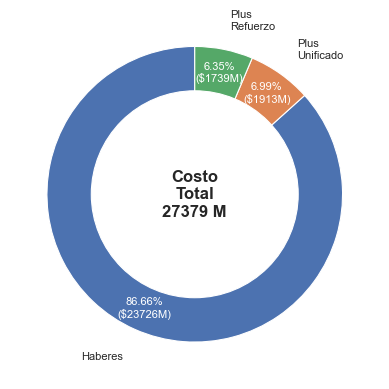

In [380]:
#COSTO TOTAL

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

costos = [ brutos["BRUTO"].sum(), brutos_plus["BRUTO"].sum(), brutos_refuerzo["BRUTO"].sum()]

sns.set_theme("paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(4,4))
sector, textos, autotextos = plt.pie(costos, autopct=lambda p:f'{p:.2f}%\n(${p*sum(costos)/1e8 :.0f}M)', 
    shadow=False, startangle=90, labels=["Haberes", "Plus\nUnificado", "Plus\nRefuerzo"], 
    labeldistance=1.2, pctdistance=0.84, textprops={"fontsize":8})

for autotext in autotextos:
    autotext.set_color('white')
    #autotext.set_weight('bold')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.text(0, 0, 'Costo\nTotal\n' + f'{sum(costos)/1e6:.0f} M', 
        ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()

#plt.title("Costo Total", loc="center", fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})

temp_pie_costo = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_pie_costo.name)
plt.show()
plt.close()


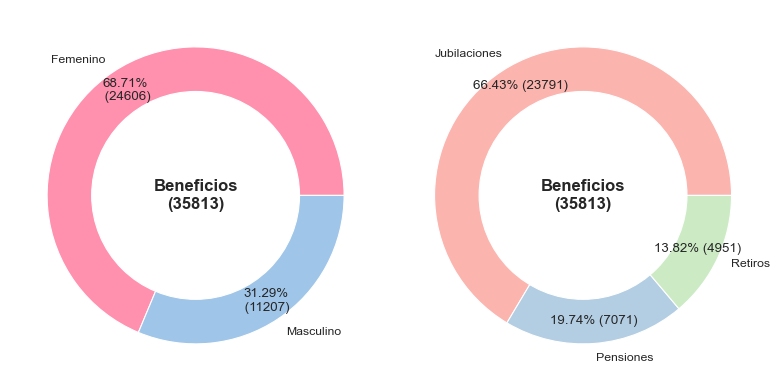

In [381]:
# CANTIDAD POR SEXO Y TIPO GENERAL
import matplotlib.pyplot as plt
from matplotlib import cm

cmap = plt.get_cmap("Pastel1")
colores = [cmap(i) for i in range(3)]

fig, axs = plt.subplots(1, 2, figsize=(8,4))

brutos["SEXO"] = brutos.apply(lambda x: "Masculino" if x["SEXO"] == "M" else 
    "Femenino" if x["SEXO"] == "F" else x["SEXO"], axis=1)

brutos.groupby("SEXO")["SEXO"].count().plot.pie(ax=axs[0], y="BRUTO",
    autopct=lambda p: f'{p:.2f}%\n ({p*len(brutos)/100:.0f})', label='', colors=
    ["#ff91af","#9fc5e8"], pctdistance=0.85)

#axs[0].set_title("Beneficios por sexo", fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})

centre_circle = plt.Circle((0,0),0.70,fc='white')
axs[0].add_artist(centre_circle)
axs[0].text(0, 0, 'Beneficios\n' + f'({len(brutos):.0f})', ha='center', va='center', fontsize=12, 
            fontweight='bold')

brutos["TIPO"] = brutos.apply(lambda x: "Retiros" if x["REPARTICION"] \
                            in ("Retiro Policial", "Retiro Carcelario")\
                            else "Pensiones" if x["TIPO"]=='pen' else \
                                'Jubilaciones', axis=1)

brutos_por_tipo_cuenta = brutos.groupby("TIPO").count()

brutos_por_tipo_cuenta.plot.pie(ax=axs[1], y="BRUTO", colors=colores, 
    autopct=lambda p:f'{p:.2f}% ({p * len(brutos)/100:.0f})', label='', 
    pctdistance=0.85)
plt.legend().remove()
#axs[1].set_title('Beneficios por Tipo',  fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
axs[1].add_artist(centre_circle)
axs[1].text(0, 0, 'Beneficios\n' + f'({len(brutos):.0f})', ha='center', 
            va='center', fontsize=12, fontweight='bold')

plt.tight_layout()

temp_pie_beneficios_sexo_tipo = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_pie_beneficios_sexo_tipo.name)
plt.show()
plt.close()

In [382]:
#PIES BRUTOS POR TIPO DE REPARTICION
from matplotlib import cm

pastel1 = plt.get_cmap("Pastel1")
pastel2 = plt.get_cmap("Pastel2")

colores = [cmap(i) for i in range(pastel1.N-1)] + \
    [pastel2(i) for i in range(pastel2.N)]

fig, axs = plt.subplots(1, 2, figsize=(8,4), tight_layout=True, sharey=True)

# Obtener las 10 primeras reparticiones con mayor BRUTO
top_10_reparticiones_bruto = brutos.groupby("TIPOREPARTICION")["BRUTO"].\
    sum().nlargest(10).index

# Calcular el total del BRUTO del resto de las reparticiones
total_resto_reparticiones_bruto = brutos[~brutos['TIPOREPARTICION'].\
    isin(top_10_reparticiones_bruto)]['BRUTO'].sum()

# Crear los datos para el gráfico de pastel
data_top_10_bruto = brutos.loc[brutos['TIPOREPARTICION'].\
    isin(top_10_reparticiones_bruto), ["TIPOREPARTICION", "BRUTO"]]

# Concatenar las series
data_top_10_bruto.loc[len(data_top_10_bruto)] = ["Otras", \
    total_resto_reparticiones_bruto]

data_top_10_bruto_grp = data_top_10_bruto.groupby("TIPOREPARTICION").sum("BRUTO")

plt.subplot(1,2,1) 

sectores, textos, autos = plt.pie(data_top_10_bruto_grp["BRUTO"], \
    labels=data_top_10_bruto_grp.index,  autopct="%1.1f%%", startangle=135,
    pctdistance=0.85, colors=colores[:11], textprops={'fontsize': 7}, 
    wedgeprops={'width': 0.5}, counterclock=False)

for i, aut in enumerate(autos):
        aut.set_fontsize(7)

centre_circle = plt.Circle((0,0),0.70,fc='white')
axs[0].add_artist(centre_circle)
axs[0].text(0, 0, 'Haber\nBruto\nTotal\n' 
            f'({sum(brutos["BRUTO"])/1e6:.0f} M)', 
            ha='center', va='center', fontsize=12, fontweight='bold')

axs[0].legend().set_visible(False)

# Obtener las 10 primeras reparticiones con mayor BRUTO
top_10_reparticiones_cantidad = brutos.groupby("TIPOREPARTICION").count() \
    .nlargest(10, "CONTROL").index

# Calcular el total del BRUTO del resto de las reparticiones
resto_reparticiones = brutos[~brutos['TIPOREPARTICION']\
    .isin(top_10_reparticiones_bruto)]

total_resto_reparticiones = resto_reparticiones.count()["CONTROL"].sum()

# Crear los datos para el gráfico de pastel
data_top_10 = brutos.loc[brutos['TIPOREPARTICION'].\
    isin(top_10_reparticiones_bruto), ["TIPOREPARTICION", "CONTROL"]]

data_top_10_grp = data_top_10.groupby("TIPOREPARTICION").count()["CONTROL"]

# Concatenar las series
data_top_10_grp = pd.concat( [data_top_10_grp, \
    pd.Series({"Otras": total_resto_reparticiones})] )

data_top_10_grp = data_top_10_grp.sort_index()  

plt.subplot(1,2,2)
sectores, textos, autos = plt.pie(x=data_top_10_grp, 
        labels=data_top_10_grp.index, autopct=lambda p:f'{p:.2f}%', 
        shadow=False, startangle=135, explode=[0.01] * len(data_top_10_grp), 
        pctdistance=0.85, colors=colores[:11], counterclock=False,
        textprops={"fontsize": 7, "color": "black"})

"""desplazar los textos para que no se pisen cuando los sectores son pequeños"""
for i, aut in enumerate(autos):
    if data_top_10_grp.iloc[i] / data_top_10_grp.sum() < 0.05:
        if ((i % 2) == 0):
            x, y = aut.get_position()
            aut.set_position((x * 0.95, y * 0.95)) 
            
for i, texto in enumerate(textos):
    if data_top_10_grp.iloc[i] / data_top_10_grp.sum() < 0.05:
        if ((i % 2) == 0):
            x, y = texto.get_position()
            texto.set_position((x * 1, y * 0.95)) 

centre_circle = plt.Circle((0,0),0.70,fc='white')
axs[1].add_artist(centre_circle)
axs[1].text(0, 0, 'Beneficios\n' f'({len(brutos):.0f})', ha='center', 
            va='center', fontsize=12, fontweight='bold')

axs[1].legend().set_visible(False)

# plt.text(0.70, -0.30, '*sobre un total de {} beneficios'.\
#     format(data_top_10_grp.sum()),fontsize=8,fontweight='normal',color='gray')

#plt.text(-1.30, -1.37, '**' + ",".join(resto_reparticiones["TIPOREPARTICION"].unique()), fontsize=6, fontweight='normal', color='gray', wrap=True, verticalalignment='top')

plt.legend().set_visible(False)
#plt.title("Beneficios por tipo de repartición", fontdict={'family': 'Arial', 'size': 12,  'weight': 'bold', 'style': 'normal'})
plt.rcParams['savefig.dpi'] = 600 

# Ajustar el layout para reducir el espacio entre los gráficos de pastel
plt.subplots_adjust(wspace=0, hspace=5)

temp_pie_brutos_tr = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_pie_brutos_tr)
#plt.show()
plt.close()

In [383]:
# PIE DE MUNICIPIOS

municipales_bruto = brutos.loc[brutos["TIPOREPARTICION"] == "Municipio"]\
    ["BRUTO"].sum()

resto_municipales_bruto = brutos[~(brutos["TIPOREPARTICION"]=="Municipio")]\
    ["BRUTO"].sum()

muni_bruto = pd.concat([pd.Series({"Municipales": municipales_bruto}), 
                        pd.Series({"Resto": resto_municipales_bruto})])

municipales_cantidad = len(brutos.loc[brutos["TIPOREPARTICION"] == "Municipio"])
resto_municipales_cantidad = len(brutos.loc[brutos["TIPOREPARTICION"] \
    != "Municipio"])

muni_cant = pd.concat([pd.Series({"Municipales": municipales_cantidad}), \
    pd.Series({"Resto": resto_municipales_cantidad})])

fig, ax = plt.subplots(1, 2, figsize=(8,4))
#plt.figtext(0.5, 0.9, 'Beneficiarios municipales', fontsize=14, ha='center')

plt.subplot(1,2,1)
plt.pie(x=muni_bruto, labels=muni_bruto.index, 
        autopct=lambda p:f'{p:.2f}% (${p*sum(muni_bruto)/1e8 :.0f} M)', 
        shadow=False, startangle=90, explode=[0.01] * len(muni_cant), 
        pctdistance=0.80, colors=colores[0:2], radius= 1.2,
        textprops={"fontsize": 8, "color": "black"})

#plt.ylabel(ylabel="Haberes brutos")
centre_circle = plt.Circle((0, 0), 0.80, fc='white')
ax[0].text(0, 0, 'Haber Bruto\nTotal\n' f'($ {sum(brutos["BRUTO"])/1e6:.0f} M)', 
           ha='center', va='center', fontsize=12, fontweight='bold')

fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

axs=plt.subplot(1,2,2)
plt.pie(x=muni_cant, labels=muni_cant.index, 
        autopct=lambda p:f'{p:.2f}% ({p*sum(muni_cant)/100 :.0f})', shadow=False,
        startangle=90,explode=[0.01] * len(muni_cant), pctdistance=0.80,
        textprops={"fontsize": 8, "color": "black"}, colors=colores[0:2],
        radius=1.2)
#plt.ylabel(ylabel="Beneficios")
# draw circle
centre_circle = plt.Circle((0, 0), 0.80, fc='white')
axs.text(0, 0, 'Beneficios\n' f'({len(brutos):.0f})', ha='center', va='center', fontsize=12,
            fontweight='bold')

fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

temp_pie_municipales = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_pie_municipales)
#plt.show()
plt.close()



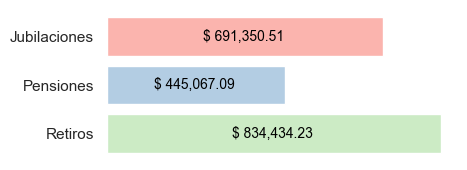

In [384]:
# HABERES BRUTOS MEDIOS ( 1 )
import seaborn as sns

sns.set_theme(style="whitegrid", palette="pastel")
sns.set_style("whitegrid")


promedios = brutos[["TIPO", "BRUTO"]].groupby("TIPO").mean(["BRUTO"])

fig, ax = plt.subplots(figsize=(5,2))
bars = ax.barh(promedios.index, promedios["BRUTO"], color=colores[0:11], 
               height=0.8)

for bar in bars:
    width = bar.get_width()
    height = bar.get_height()
    y = bar.get_y()
    ax.text(width/2, y + height / 2, f'$ {width:,.2f} ', ha='center', va='center',
        c='black', fontsize=10)
    
# Eliminar los bordes del gráfico (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Opcional: Eliminar las marcas de los ejes
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_visible(False)
ax.xaxis.set_ticks_position('none')

ax.invert_yaxis()
ax.grid(False)

#ax.set_title(label="Haber Bruto\nMedio", y=-0.2)
'''AJUSTO EL ESPACIO ENTRE EL EJE Y EL TEXTO'''
plt.subplots_adjust(left=0.20, right=0.9, top=0.9, bottom=0.15)
plt.ylabel("")
plt.xlabel("")

#plt.legend().set_visible(False)
temp_bar_haberes_medios = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_bar_haberes_medios)
plt.show()
plt.close()

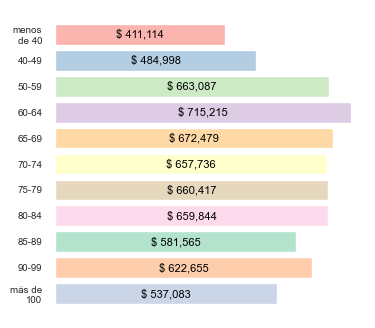

In [385]:
# HABERES BRUTOS MEDIOS ( 2 )

grupos_etarios_bruto = [0, 40, 50, 60, 65, 70, 75, 80, 85, 90, 100, 110]
etiquetas_geb = ["menos\nde 40", "40-49","50-59","60-64","65-69","70-74",
    "75-79", "80-84", "85-89", "90-99", "más de\n100"]

brutos["grupo_etario_bruto"] = pd.cut(brutos["EDAD"], bins=grupos_etarios_bruto,
    labels= etiquetas_geb, ordered=False)

fig, ax = plt.subplots(figsize=(4,4))
brutos_edades = brutos.groupby("grupo_etario_bruto", observed=False)["BRUTO"].mean()

ax = plt.subplot()
bars = plt.barh(y=brutos_edades.index, width=brutos_edades.values, 
    label="", color=colores)
ax.tick_params(axis="y", labelsize=7)

for bar in bars:
    height = bar.get_height()
    width = bar.get_width()
    pos_y = bar.get_y()
    ax.text(
        (width/2),
        pos_y + height / 2,
        f'$ {width:,.0f}',                  
        ha='center',                       
        va='center',                         
        rotation='horizontal',
        c="black",
        fontsize=8
    )

# Eliminar los bordes del gráfico (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Opcional: Eliminar las marcas de los ejes
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_visible(False)
ax.yaxis.set_ticks_position('none')

ax.invert_yaxis()
ax.grid(False)

#ax.set_title(label="Haber bruto medio", y=-0.2)

plt.xlabel("")
plt.ylabel("")

temp_bar_brutos_edad = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_bar_brutos_edad)

plt.show()
plt.close()

In [386]:
# HBAR CANTIDAD POR GRUPOS ETARIOS

grupos_etarios_cantidad = [0, 40, 50, 60, 65, 70, 75, 80, 85, 90, 100, 110]
etiquetas_gec = ["menos\nde 40", "40-49","50-59","60-64","65-69","70-74",
    "75-79", "80-84", "85-89", "90-99", "más de\n100"]

brutos["grupo_etario_cantidad"] = pd.cut(brutos["EDAD"], 
    bins=grupos_etarios_cantidad,
    labels=etiquetas_gec)

cantidad_edades = brutos.groupby("grupo_etario_cantidad", observed=False)\
    ["CONTROL"].count()

fig, ax = plt.subplots(figsize=(4,4))
bars = plt.barh(cantidad_edades.index, cantidad_edades.values, 
    label="", color=colores)
ax.tick_params(axis="y", labelsize=7)
for bar in bars:
    height = bar.get_height()
    width = bar.get_width()
    col="black" ##8dc049" if width < 900 else "white"
    ha = 'center' if width > 900 else 'left'
    ax.text(
        (width/2),
        bar.get_y() + height / 2,
        f'{width:.0f}',                  # Texto (valor formateado en miles)
        ha=ha,                       # Alineación horizontal
        va='center',                         # Alineación vertical
        rotation='horizontal',
        c=col,
        fontsize=8
    )


# Eliminar los bordes del gráfico (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Opcional: Eliminar las marcas de los ejes
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_visible(False)
ax.yaxis.set_ticks_position('none')

ax.invert_yaxis()
ax.grid(False)

#ax.set_title(label="Beneficios", y=-0.2)

plt.xlabel("")
plt.ylabel("")

temp_bar_cantidad_edad = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_bar_cantidad_edad)

#plt.show()
plt.close()

In [387]:
# CANTIDAD DE BENEFICIOS POR LOCALIDAD -DATOS
  
loc_cantidad = brutos["LOCALIDAD"].groupby(brutos["LOCALIDAD"]).count().\
    nlargest(20)
    
otras_loc_cantidad = brutos.loc[~(brutos["LOCALIDAD"].isin(loc_cantidad.index))].groupby("LOCALIDAD")["LOCALIDAD"].count()

otras_loc_cantidad_localidades = ", ".join(otras_loc_cantidad.index)

loc_cantidad = pd.concat([loc_cantidad, pd.Series({"RESTO": otras_loc_cantidad.sum()})])



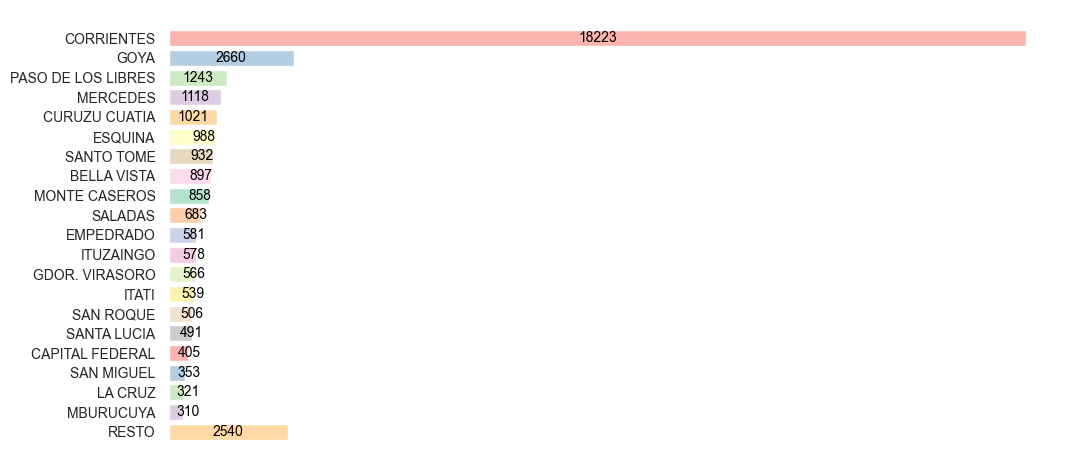

In [388]:

# HBARS CANTIDAD DE BENEFICIOS POR LOCALIDAD
fig, ax = plt.subplots(figsize=(12,6))
bars = ax.barh(loc_cantidad.index, loc_cantidad.values, color=colores)

for bar in bars:
    height = bar.get_height()
    width = bar.get_width()
    ha = 'center' if width >= 1000 else 'left'
    # Agregamos el texto de la cantidad de registros por cada localidad
    ax.text(
        (width/2),
        bar.get_y() + height / 2,
        f'{width:.0f}',                  
        ha=ha,                       
        va='center',                         
        rotation='horizontal',
        c="black",
        fontsize=10
    )
    
# Eliminar los bordes del gráfico (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Opcional: Eliminar las marcas de los ejes
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_visible(False)
ax.yaxis.set_ticks_position('none')

ax.invert_yaxis()
ax.grid(False)

plt.xticks(rotation=45, ha="right")
ax.set_xlabel("")
ax.set_ylabel("")

#cambiar tamaño de la fuente del eje y
ax.tick_params(axis="y", labelsize=10)

# AJUSTO EL ESPACIO ENTRE EL EJE Y EL TEXTO
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)

temp_barh_loc_cant = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_barh_loc_cant)

plt.show()
plt.close()# FIN



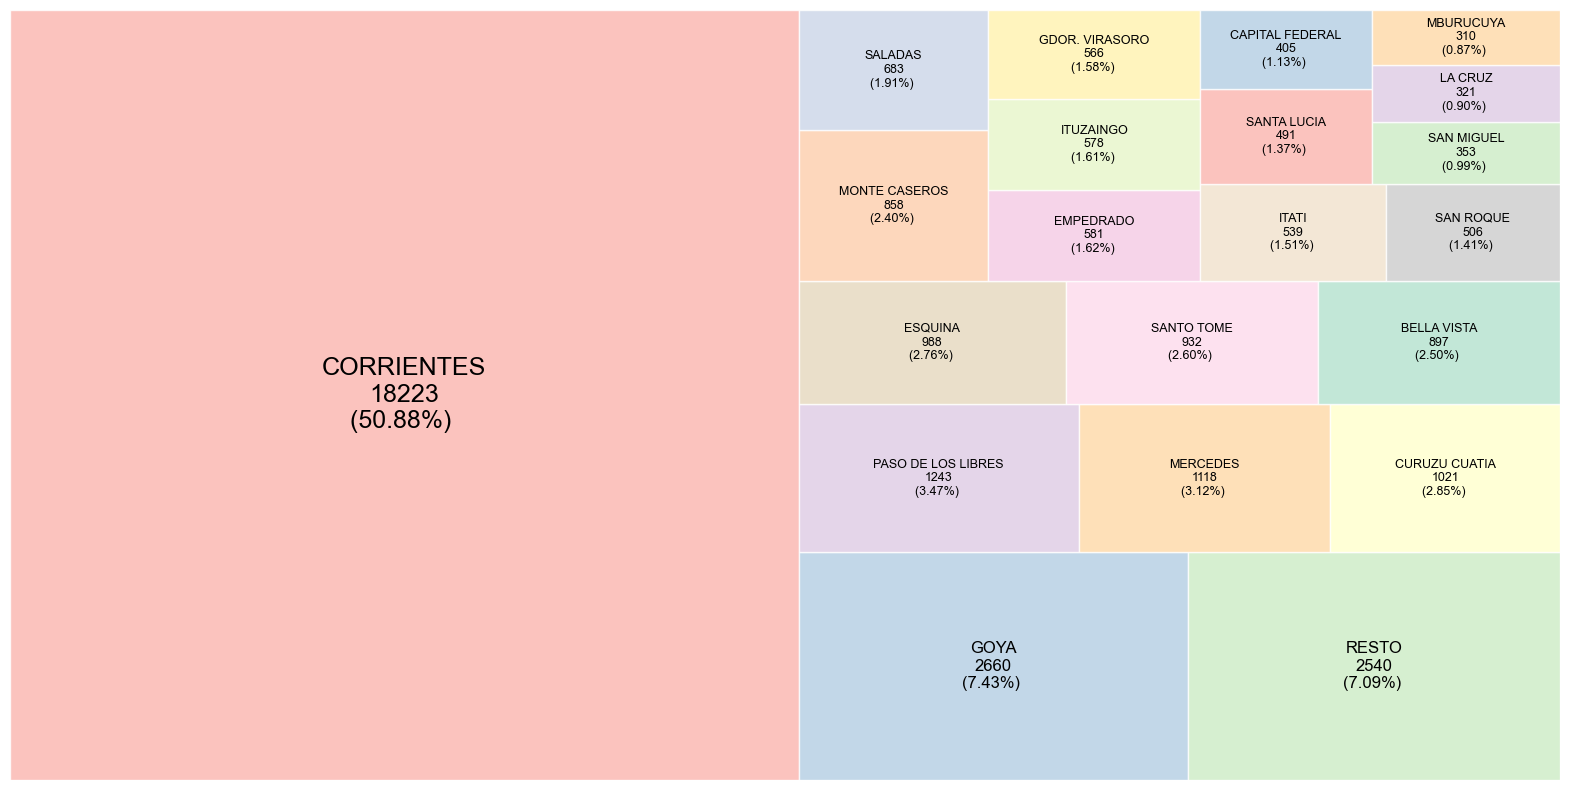

In [389]:
# TREEMAP CANTIDAD DE BENEFICIOS POR LOCALIDAD -DATOS

# TREEMAP DE BRUTOS POR LOCALIDAD
import matplotlib.pyplot as plt
import squarify

# cmap = plt.get_cmap("Greens")
# colores = [cmap(i) for i in range(100, 0, -10)]
loc_cantidad.sort_values(ascending=False, inplace=True)

# Crear el treemap
rects = squarify.normalize_sizes(loc_cantidad.values, 100, 100)
rects = squarify.squarify(rects, 0, 0, 100, 100)

max_size = max(loc_cantidad.values)
total = sum(loc_cantidad.values)

# Crear la figura
fig, ax = plt.subplots(figsize=(20, 10))

# Dibujar los rectángulos
squarify.plot(sizes=loc_cantidad.values, ax=ax, alpha=.8, color=colores)

# Personalizar las etiquetas
for rect, label, size in zip(rects, loc_cantidad.index, loc_cantidad.values):
    x = rect['x'] + rect['dx'] / 2
    y = rect['y'] + rect['dy'] / 2

    # Calcular el porcentaje del tamaño respecto al total
    percentage = size/total
    
    # Crear la etiqueta con el nombre y el porcentaje
    label_with_size = f"{label}\n{size:.0f}\n({percentage*100:.2f}%) "
    
    # Escala del tamaño de fuente
    if size >= 0.6 * max_size:
        fontsize = 18  # Mayor tamaño
    elif size >= 0.1 * max_size:
        fontsize = 12  # Tamaño medio
    else:
        fontsize = 9  # Menor tamaño
    
    # Agregar la etiqueta y el porcentaje
    ax.text(x, y, label_with_size, ha='center', va='center', 
            fontsize=fontsize, fontname='Arial', color='black')

# Remover los ejes
ax.axis('off')

# Mostrar el gráfico
# plt.show()

temp_treemap_loc_cantidad = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
plt.savefig(temp_treemap_loc_cantidad)


In [390]:
# HABERES BRUTOS POR LOCALIDAD - DATOS

loc_bruto = brutos.groupby("LOCALIDAD").sum(["BRUTO"])["BRUTO"].nlargest(20)

otras_loc_bruto = brutos.loc[~brutos["LOCALIDAD"].isin(loc_bruto.index), 
                             ["LOCALIDAD", "BRUTO"]]

otras_loc_brutos_localidades = ", ".join(otras_loc_bruto["LOCALIDAD"].\
    value_counts().index.sort_values())

cant_otras_loc_bruto = len(otras_loc_bruto)

loc_bruto = pd.concat([loc_bruto, pd.Series({ f"*RESTO":
    otras_loc_bruto.groupby("LOCALIDAD").sum(["BRUTO"])["BRUTO"].sum()})])



In [391]:
# HBARS BRUTOS POR LOCALIDAD

fig, ax = plt.subplots(figsize=(12,6))
bars = ax.barh(loc_bruto.index, loc_bruto.values, color=colores)

for bar in bars:
    height = bar.get_height()
    width = bar.get_width()
    # Agregamos el texto de la cantidad de registros por cada localidad
    ax.text(
        (width/2) if (width > 1e9) else (width + 0.3),
        bar.get_y() + height / 2,
        f'$ {width/1e6 :.2f} M',                  
        ha= 'center' if width > 1e9 else 'left',                       
        va='center',                         
        rotation='horizontal',
        c="black",
        fontsize=10
    )
    

# Eliminar los bordes del gráfico (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Opcional: Eliminar las marcas de los ejes
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_visible(False)
ax.yaxis.set_ticks_position('none')


ax.invert_yaxis()
ax.grid(False)

plt.xticks(rotation=45, ha="right")
ax.set_xlabel("")
ax.set_ylabel("")

#cambiar tamaño de la fuente del eje y
ax.tick_params(axis="y", labelsize=10)


'''AJUSTO EL ESPACIO ENTRE EL EJE Y EL TEXTO'''
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)

temp_barh_loc_bruto = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_barh_loc_bruto)

# plt.show()
plt.close()


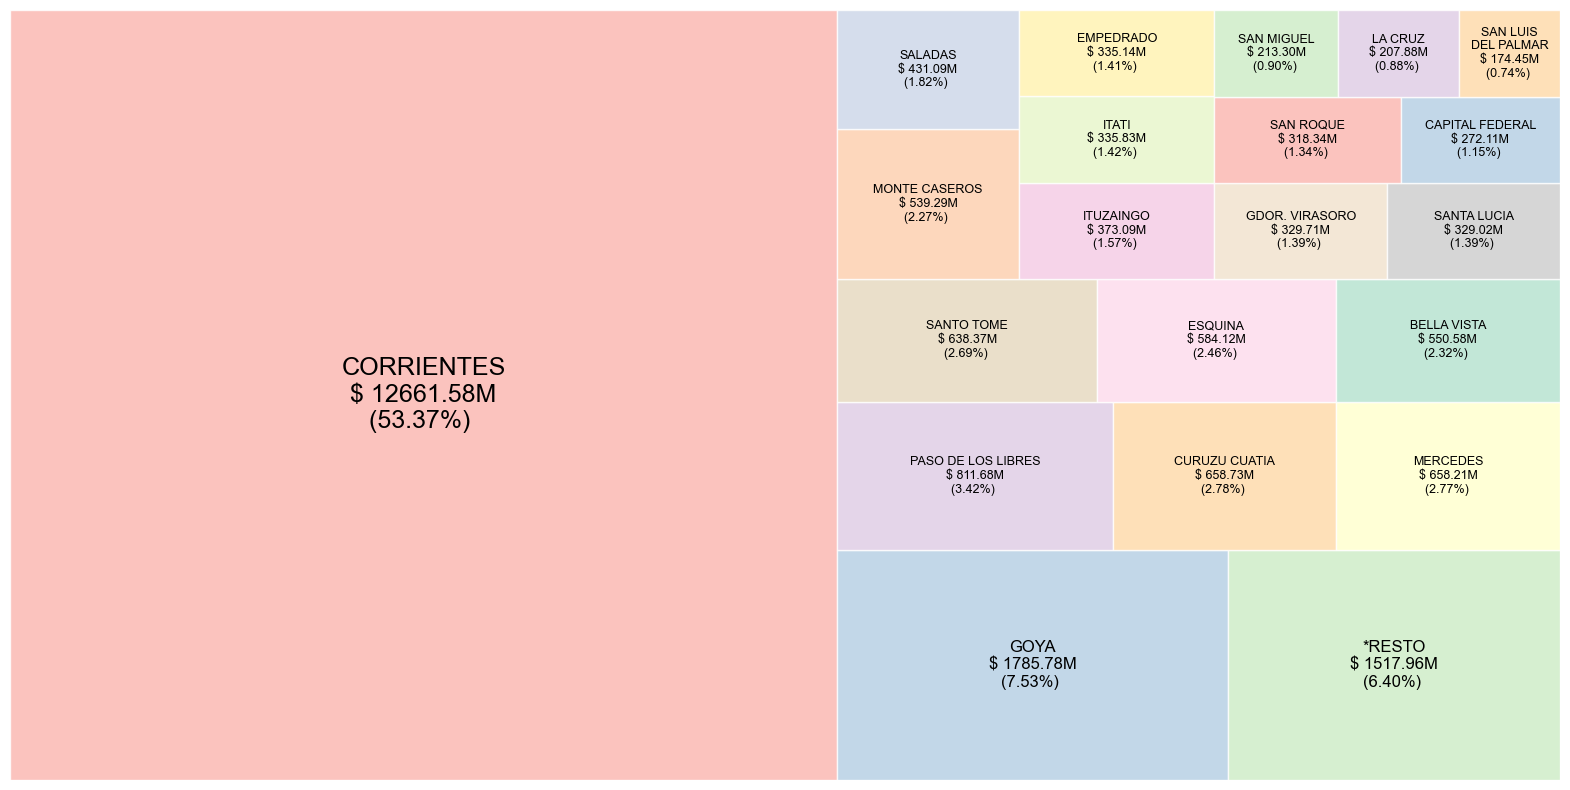

In [392]:
# TREEMAP DE BRUTOS POR LOCALIDAD
import matplotlib.pyplot as plt
import squarify

# cmap = plt.get_cmap("Greens")
# colores = [cmap(i) for i in range(100, 0, -10)]
loc_bruto.sort_values(ascending=False, inplace=True)

# Crear el treemap
rects = squarify.normalize_sizes(loc_bruto.values, 100, 100)
rects = squarify.squarify(rects, 0, 0, 100, 100)

max_size = max(loc_bruto.values)
total = sum(loc_bruto.values)

# Crear la figura
fig, ax = plt.subplots(figsize=(20, 10))

# Dibujar los rectángulos
squarify.plot(sizes=loc_bruto.values, ax=ax, alpha=.8, color=colores)

# Personalizar las etiquetas
for rect, label, size in zip(rects, loc_bruto.index, loc_bruto.values):
    x = rect['x'] + rect['dx'] / 2
    y = rect['y'] + rect['dy'] / 2

    # Calcular el porcentaje del tamaño respecto al total
    percentage = size/total
    
    # Crear la etiqueta con el nombre y el porcentaje
    label_with_size = f"{label}\n$ {size/1e6:.2f}M\n({percentage*100:.2f}%) "
    
    # Escala del tamaño de fuente
    if size >= 0.6 * max_size:
        fontsize = 18  # Mayor tamaño
    elif size >= 0.1 * max_size:
        fontsize = 12  # Tamaño medio
    else:
        fontsize = 9  # Menor tamaño
    
    # Agregar la etiqueta y el porcentaje
    ax.text(x, y, label_with_size, ha='center', va='center', 
            fontsize=fontsize, fontname='Arial', color='black')

# Remover los ejes
ax.axis('off')

# Mostrar el gráfico
# plt.show()

temp_treemap_loc_bruto = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
plt.savefig(temp_treemap_loc_bruto)


In [393]:
## ALTAS Y BAJAS MENSUALES - CRECIMIENTO VEGETATIVO
from datetime import datetime, timedelta

# Obtener la fecha actual
hoy = datetime.strptime(liquidacion + "-01", '%Y-%m-%d')

# Crear una lista de los últimos 12 meses en formato yyyy-mm
ultimos_12_meses = [(hoy - pd.DateOffset(months=i)).strftime('%Y-%m') for i in range(14)]

# Invertir la lista para que esté en orden cronológico
#ultimos_12_meses = ultimos_12_meses[::-1]

cons_altas = ''
cons_bajas = ''
for i in range(0,len(ultimos_12_meses)-1):
    cons_altas += f'SELECT \'{ultimos_12_meses[i]}\' as MES, CONTROL FROM' +\
    f'[{ultimos_12_meses[i]}].dbo.DATOSAFILIADO D1 WHERE CONTROL NOT IN' +\
    f'\n(SELECT CONTROL FROM [{ultimos_12_meses[i+1]}].dbo.DATOSAFILIADO)' 
    cons_altas += (f' UNION\n' if i < (len(ultimos_12_meses)-2) else '')
    
    cons_bajas += f'SELECT \'{ultimos_12_meses[i]}\' as MES, CONTROL FROM ' +\
    f'[{ultimos_12_meses[i+1]}].dbo.DATOSAFILIADO D1 WHERE CONTROL NOT IN' +\
    f'\n(SELECT CONTROL FROM [{ultimos_12_meses[i]}].dbo.DATOSAFILIADO)' 
    cons_bajas += (f' UNION\n' if i < (len(ultimos_12_meses)-2) else '')

altas = pd.read_sql(cons_altas, engine)
bajas = pd.read_sql(cons_bajas, engine)



In [394]:
# ALTAS Y BAJAS MENSUALES, CRECIMIENTO VEGETATIVO

fig, axs = plt.subplots(1,1, figsize=(6,4), sharex=True, sharey=True)

resumen_altas = altas.groupby("MES").count()["CONTROL"]
resumen_bajas = bajas.groupby("MES").count()["CONTROL"]

# calculo del crecimiento vegetativo
crec_veg = pd.merge(resumen_altas, resumen_bajas, on="MES", how="inner")
crec_veg["crec"]=crec_veg["CONTROL_x"]-crec_veg["CONTROL_y"]
crec_veg["cumsum"] = crec_veg["crec"].cumsum() 

axs.plot(resumen_altas, color="#5bc217", marker="", label="Altas")
axs.plot(resumen_bajas, color="#428b11", marker="", label="Bajas")
axs.plot(crec_veg["crec"], color="#5bc217", label="Crec. Veg.", linestyle="dotted")
# axs.plot(crec_veg["cumsum"], color="red", label="CV acum", linestyle="dashed")

# Eliminar los bordes del gráfico (spines)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(True)

# Opcional: Eliminar las marcas de los ejes
# axs.xaxis.set_ticks_position('none')
# axs.xaxis.set_visible(False)
# axs.yaxis.set_ticks_position('none')

axs.grid(False)

plt.xticks(rotation=0, ha="right")
meses = [m[0:3] for m in meses_liq[0:12]]
axs.set_xticklabels(f'{ meses[int(x[-2:])-1] }' f'\n' f'{x[2:4]}' 
                    for x in (altas.groupby("MES").count()["CONTROL"].index)
                    if x[2:4])
# axs.set_xlabel("")
# axs.set_ylabel("")

#cambiar tamaño de la fuente del eje y
axs.tick_params(axis="y", labelsize=8)
plt.legend()

'''AJUSTO EL ESPACIO ENTRE EL EJE Y EL TEXTO'''
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)

temp_line_crec_veg = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_line_crec_veg)
# plt.show()
plt.close()

C:\Users\25030055\AppData\Local\Temp\ipykernel_13508\70487668.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(f'{ meses[int(x[-2:])-1] }' f'\n' f'{x[2:4]}'


In [395]:
""" REPORTE """
from reportlab.lib.pagesizes import A4, landscape
from reportlab.lib.units import mm
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfmetrics

pdfmetrics.registerFont(TTFont('Archivo Bk', 'resources/ArchivoBlack-Regular.ttf'))
pdfmetrics.registerFont(TTFont('DM Sans', 'resources/DMSans.ttf'))
pdfmetrics.registerFont(TTFont('DM Sans Black', 'resources/DMSans.ttf', subfontIndex=9))

# Crear el PDF usando ReportLab
pdf_file = f'informe {titulo_liquidacion}.pdf'
c = canvas.Canvas('informes/' + pdf_file, pagesize=landscape(A4))
c.setFont("DM Sans", 12)

def cabecera_pie():
    c.saveState()
    c.setFontSize(32)
    c.drawImage("resources/pie.png", 0, -10, landscape(A4)[0], 65, 
                preserveAspectRatio=True, mask='auto')
    c.setFont('DM Sans Black', 14)
    c.setFillColor('white')
    c.drawCentredString(x=A4[1]/2, y=15,
                    text=titulo_liquidacion)
    c.restoreState()


In [396]:
""" CARATULA """

cabecera_pie()

c.setFont('Archivo Bk', 64)
c.setFillColor("#48c631")

c.drawImage("resources/logoIPS.png", x=350, y=130, width=100, 
    preserveAspectRatio=True)
    
c.drawCentredString(text="INFORME MENSUAL", x=A4[1]/2, y=350, charSpace=-5)
c.setFont('Archivo Bk', 40)
c.drawCentredString(text="Sistema de Gestión Previsional", x=A4[1]/2, y=300, charSpace=-5)

c.showPage()



In [397]:
""" PRIMERA PAGINA """

cabecera_pie()
# Insertar el gráfico en el PDF
c.drawImage(temp_pie_costo.name, 30, 80, A4[1]-60, 450, preserveAspectRatio=True)
temp_pie_costo.close()

c.showPage()


In [398]:
""" HABERES MEDIOS """
cabecera_pie()
c.setFillColor('black')
c.drawCentredString(380, 180, "Haber bruto promedio")
c.drawImage(temp_bar_haberes_medios.name, 60, 200, width=A4[1]-60, 
            height=300, preserveAspectRatio=True, mask="auto")

temp_bar_haberes_medios.close()
c.showPage()

In [399]:
"""" SEGUNDA PAGINA """
cabecera_pie()

c.drawImage(temp_pie_beneficios_sexo_tipo.name, 20,120,800,400, 
            preserveAspectRatio=True)

c.showPage()
temp_pie_beneficios_sexo_tipo.close()


In [400]:
""" TERCERA PAGINA """
cabecera_pie()

#c.setPageSize(landscape(A4))
c.drawImage(temp_pie_brutos_tr.name, 20, 60, width=A4[1]-30, height=A4[0], 
            preserveAspectRatio=True)

c.showPage()
temp_pie_brutos_tr.close()



In [401]:
""" CUARTA PAGINA """
cabecera_pie()
c.drawImage(temp_pie_municipales.name, 15, 10, width=A4[1]-20, height=A4[0], 
            preserveAspectRatio=True)

c.showPage()
temp_pie_municipales.close()


In [402]:
""" QUINTA PAGINA """
cabecera_pie()
c.drawImage(temp_bar_brutos_edad.name, 15, 30, width=(A4[1]/2)-20, 
            height=A4[0]-20, preserveAspectRatio=True)

c.drawImage(temp_bar_cantidad_edad.name, (A4[1]/2)+20, 30, width=(A4[1]/2)-20, 
            height=A4[0]-20, preserveAspectRatio=True)

c.setFillColor("black") 
c.drawString(150,105, "Haberes brutos promedio")
c.drawString(625,105, "Beneficios")

c.setFontSize(16)
c.drawCentredString(x=A4[1]/2,y=515, text="Por Rangos Etarios")

temp_bar_brutos_edad.close

c.showPage()
temp_bar_haberes_medios.close()




In [403]:
# """ SEXTA PAGINA"""

# cabecera_pie()

# c.drawImage(temp_barh_loc_bruto.name, 30, 60, width=(A4[1]),height=A4[0]-30,
#             preserveAspectRatio=True, mask="auto")


# c.setFont("DM Sans Black", 14)
# c.drawCentredString(x=A4[1]/2, y=190, text="Totales de haber bruto por localidad"
#                     " (boca de pago)")

# # agregar listado del RESTO

# c.setFontSize(8)
# for i in range(0,len(otras_loc_brutos_localidades) % 80,1):
#     c.drawString(30, 150 - (9*i), 
#                 ("*" if i==0 else "") + 
#                 otras_loc_brutos_localidades[i*80: (i*80)+80])


# temp_barh_loc_bruto.close()

# c.showPage()


In [404]:
# """ SEPTIMA PAGINA """
# cabecera_pie()
# c.drawImage(temp_barh_loc_cant.name, 30, 60, width=(A4[1]),height=A4[0]-30,
#             preserveAspectRatio=True, mask="auto")

# c.setFont("DM Sans Black", 14)
# c.drawCentredString(x=A4[1]/2, y=190, text="Beneficios por localidad"
#                     " (boca de pago)")
# c.setFontSize(8)
# for i in range(0,len(otras_loc_cantidad_localidades) % 80,1):
#     c.drawString(30, 150 - (9*i), 
#                 ("*" if i==0 else "") + 
#                 otras_loc_cantidad_localidades[i*80: (i*80)+80])

# temp_barh_loc_cant.close()

# c.showPage()

In [405]:
## TREE MAP CANTIDAD POR LOCALIDAD

cabecera_pie()

c.drawImage(temp_treemap_loc_cantidad.name, 10, 10, width=(A4[1]),
            height=A4[0], preserveAspectRatio=True, mask="auto")

c.setFont("DM Sans Black", 14)
c.drawCentredString(x=A4[1]/2, y=120, text="Total de Beneficios por Localidad")
# c.drawCentredString(x=A4[1]/2, y=105, text="(cantidad de beneficios)")

c.setFontSize(8)
for i in range(0,len(otras_loc_cantidad_localidades) % 80,1):
    c.drawString(30, 150 - (9*i), 
                ("*" if i==0 else "") + 
                otras_loc_cantidad_localidades[i*80: (i*80)+80])
c.showPage()
temp_treemap_loc_cantidad.close()



In [406]:
## TREE MAP BRUTOS POR LOCALIDAD

cabecera_pie()

c.drawImage(temp_treemap_loc_bruto.name, 10, 10, width=(A4[1]),
            height=A4[0], preserveAspectRatio=True, mask="auto")

c.setFont("DM Sans Black", 14)
c.drawCentredString(x=A4[1]/2, y=120, text="Total de Haberes Brutos por Localidad")
# c.drawCentredString(x=A4[1]/2, y=105, text="(cantidad de beneficios)")

c.showPage()
temp_treemap_loc_bruto.close()

In [407]:
## CRECIMIENTO VEGETATIVO
cabecera_pie()

c.drawImage(temp_line_crec_veg.name, 120, 100, 
            width=(A4[1]-240),height=A4[0]-100,
            preserveAspectRatio=True, mask="auto")

c.setFont("DM Sans Black", 14)
c.drawCentredString(x=A4[1]/2, y=120, text="Altas/Bajas/Crecimiento Vegetativo")
c.drawCentredString(x=A4[1]/2, y=105, text="(cantidad de beneficios)")


c.showPage()
temp_line_crec_veg.close()

In [408]:
c.save()

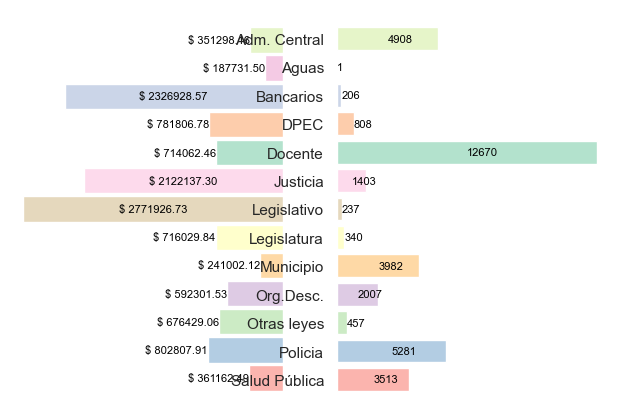

In [409]:
# MEDIO POR REPARTICION (BAR)
medios_por_rep = brutos[["TIPOREPARTICION", "BRUTO"]].groupby("TIPOREPARTICION").mean(["BRUTO"])
medios_por_rep.sort_index(ascending=False, inplace=True)

fig, ax = plt.subplots(1,2, figsize=(10,5))
bars = ax[0].barh(medios_por_rep.index, medios_por_rep["BRUTO"], color=colores, 
        height=0.9)

for bar in bars:
    height = bar.get_height()
    width = bar.get_width()
    # Agregamos el texto de la cantidad de registros por cada localidad
    ax[0].text(
        (width/2) if (width > 15*1e5) else (width + 0.3),
        bar.get_y() + height / 2,
        f'$ {width :.2f}',                  
        ha= 'center' if width > 15*1e5 else 'right',                       
        va='center',                         
        rotation='horizontal',
        c="black",
        fontsize=8
    )

    
# Eliminar los ejes

# Opcional: Eliminar las marcas de los ejes
ax[0].xaxis.set_ticks_position('none')
ax[1].xaxis.set_ticks_position('none')
ax[0].yaxis.set_ticks_position('none')
ax[1].yaxis.set_ticks_position('none')

ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
# ax[1].set_yticklabels(medios_por_rep.index, ha='center')

ax[0].invert_xaxis()

ax[0].tick_params(axis="y", labelsize=9)
ax[0].grid(False)
plt.grid(False)

cuenta_por_rep = brutos[["TIPOREPARTICION", "BRUTO"]].groupby("TIPOREPARTICION").count()
cuenta_por_rep.sort_index(ascending=False, inplace=True)
    
    
# Eliminar el cuadro alrededor del gráfico
for spine in ax[0].spines.values():
    spine.set_visible(False)
    
for spine in ax[1].spines.values():
    spine.set_visible(False)
    
bars1 = ax[1].barh(y= cuenta_por_rep.index, width=cuenta_por_rep["BRUTO"], color=colores)
for bar in bars1:
    height = bar.get_height()
    width = bar.get_width()
    # Agregamos el texto de la cantidad de registros por cada localidad
    ax[1].text(
        (width/2) if (width > 1000) else (width + 0.3),
        bar.get_y() + height / 2,
        f'{width :.0f}',                  
        ha= 'left', #'center' if width > 1000 else 'left',                       
        va='center',                         
        rotation='horizontal',
        c="black",
        fontsize=8
    )


'''AJUSTO EL ESPACIO ENTRE EL EJE Y EL TEXTO'''
plt.subplots_adjust(left=0.1, right=0.7, top=0.9, bottom=0.1)
# plt.tight_layout()


temp_barh_tipo_rep = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_barh_tipo_rep)

plt.show()
